 ## Step 1 - Packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys

In [2]:
print(f"Python version -> {sys.version}")  # 3.12.3
print(f"torch version -> {torch.__version__}")  # 2.8.0+cu128

Python version -> 3.13.3 (tags/v3.13.3:6280bb5, Apr  8 2025, 14:47:33) [MSC v.1943 64 bit (AMD64)]
torch version -> 2.9.1+cpu


 ## Step 2 - Load and Prepare Data

In [3]:
data_path = Path().cwd().parent / "data"
data = pd.read_csv(data_path / "heart.csv", sep=";")

x = data[
    ["Age", "RestingBP", "Cholesterol", "FastingBS", "MaxHR", "Oldpeak"]
].values.astype(np.float32)
y = data[["HeartDisease"]].values.astype(np.float32)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=123
)

# Convert to torch tensors
x_train_tensor = torch.tensor(x_train)
y_train_tensor = torch.tensor(y_train)
x_test_tensor = torch.tensor(x_test)
y_test_tensor = torch.tensor(y_test)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

print("Train data:", x_train_tensor.shape)
print("Test data :", x_test_tensor.shape)

Train data: torch.Size([734, 6])
Test data : torch.Size([184, 6])


 ## Step 3 - Define the Model

In [4]:
class HeartDiseaseModel(nn.Module):
    def __init__(self, input_dim):
        super(HeartDiseaseModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 4)
        self.layer2 = nn.Linear(4, 8)
        self.output = nn.Linear(8, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.sigmoid(self.output(x))
        return x


input_dim = x_train.shape[1]
model = HeartDiseaseModel(input_dim)
print(model)

HeartDiseaseModel(
  (layer1): Linear(in_features=6, out_features=4, bias=True)
  (layer2): Linear(in_features=4, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


 ## Step 4 - Train

In [5]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 300
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_acc = correct_val / total_val
    val_losses.append(val_loss / len(test_loader))
    val_accs.append(val_acc)

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(
            f"Epoch [{epoch+1}/{epochs}] Loss: {train_losses[-1]:.4f} Acc: {train_acc*100:.2f}% | Val_Loss: {val_losses[-1]:.4f} Val_Acc: {val_acc*100:.2f}%"
        )

Epoch [1/300] Loss: 1.9659 Acc: 55.18% | Val_Loss: 1.1923 Val_Acc: 55.98%
Epoch [10/300] Loss: 0.6037 Acc: 67.30% | Val_Loss: 0.5982 Val_Acc: 68.48%
Epoch [20/300] Loss: 0.5768 Acc: 70.84% | Val_Loss: 0.5898 Val_Acc: 69.57%
Epoch [30/300] Loss: 0.5556 Acc: 71.53% | Val_Loss: 0.5904 Val_Acc: 69.57%
Epoch [40/300] Loss: 0.5393 Acc: 73.57% | Val_Loss: 0.5681 Val_Acc: 71.74%
Epoch [50/300] Loss: 0.5242 Acc: 75.07% | Val_Loss: 0.5613 Val_Acc: 72.83%
Epoch [60/300] Loss: 0.5139 Acc: 75.61% | Val_Loss: 0.5593 Val_Acc: 72.83%
Epoch [70/300] Loss: 0.4937 Acc: 75.89% | Val_Loss: 0.5424 Val_Acc: 72.83%
Epoch [80/300] Loss: 0.4861 Acc: 77.52% | Val_Loss: 0.5340 Val_Acc: 72.83%
Epoch [90/300] Loss: 0.4861 Acc: 77.25% | Val_Loss: 0.5311 Val_Acc: 73.91%
Epoch [100/300] Loss: 0.4774 Acc: 77.11% | Val_Loss: 0.5108 Val_Acc: 73.37%
Epoch [110/300] Loss: 0.4758 Acc: 76.98% | Val_Loss: 0.5105 Val_Acc: 74.46%
Epoch [120/300] Loss: 0.4649 Acc: 78.75% | Val_Loss: 0.4952 Val_Acc: 75.00%
Epoch [130/300] Loss: 0

 ## Step 5 - Evaluate

In [6]:
model.eval()
with torch.no_grad():
    y_pred = model(x_test_tensor)
    y_pred_class = (y_pred > 0.5).float()

test_loss = criterion(y_pred, y_test_tensor).item()
test_acc = (y_pred_class == y_test_tensor).float().mean().item()

print(f"Test loss     : {test_loss:.4f}")
print(f"Test accuracy : {test_acc:.4f}")

Test loss     : 0.4861
Test accuracy : 0.7663


 ## Step 6 - Visualization

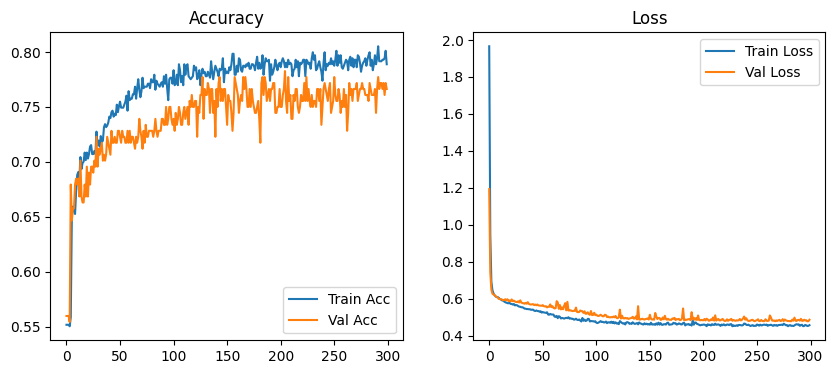

In [7]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss")
plt.show()

 ## Step 7 - Metrics

In [8]:
y_true = y_test_tensor.numpy().flatten()
y_pred_np = y_pred_class.numpy().flatten()

print(confusion_matrix(y_true, y_pred_np))
print(classification_report(y_true, y_pred_np))

[[60 21]
 [22 81]]
              precision    recall  f1-score   support

         0.0       0.73      0.74      0.74        81
         1.0       0.79      0.79      0.79       103

    accuracy                           0.77       184
   macro avg       0.76      0.76      0.76       184
weighted avg       0.77      0.77      0.77       184

